# Imports

In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import os
import time
from datetime import datetime

from threading import Thread
import IPython
import IPython.display

import numpy as np
from math import *

import tensorflow as tf
from tensorflow.keras.layers import LSTM, LeakyReLU ,Flatten , Dense,Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

import matplotlib.pyplot as plt
from pltfigure import pltfigure

# Tensorflow Check

In [56]:
print(tf.__version__)

2.8.0


In [57]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.test.is_built_with_cuda()

True

In [58]:
tf.executing_eagerly()

True

# DATASET

In [59]:
InputData = np.genfromtxt('Data/InputDataBenchmark.csv',delimiter=",")
t = np.genfromtxt('Data/timeBenchmark.csv',delimiter=",")
Data = np.genfromtxt('Data/OutputDataBenchmark.csv',delimiter=",")
print(f"OutData: %s, \nInputData: %s, \nTime: %s" %(np.shape(Data),np.shape(InputData),np.shape(t)))

OutData: (400, 28), 
InputData: (28, 6), 
Time: (400,)


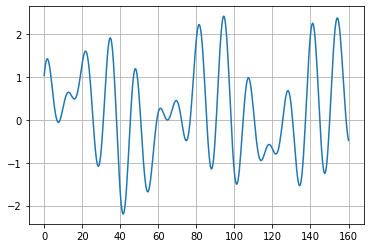

In [60]:
example_ind = 5

plt.plot(t,Data[:,example_ind])
plt.grid()

# Simple Pipeline

In [61]:
from InputPipeline import SimplePipeline

## Apply Pipeline to make Data

In [67]:
pipe = SimplePipeline(num_samples=np.shape(InputData)[0], n_steps=20, xshape=np.shape(t)[0],val_cases = 2,use_metadata=True)

In [68]:
x_inp, y_out= pipe.makeData(data=Data.T,metadata=InputData)
print(f"Input X Shape: {x_inp.shape}")
print(f"Output Y Shape: {y_out.shape}")
print(f"Metadata Added Shape: {InputData.shape}")

Input X Shape: (10640, 26)
Output Y Shape: (10640,)
Metadata Added Shape: (28, 6)


## Plot Data

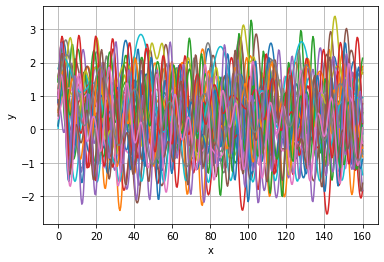

In [69]:
pipe.plotAlldata(Data.T,t)

## Split Data

In [70]:
x_inp_train ,y_out_train ,x_inp_val  ,y_out_val = pipe.split_data(x_inp,y_out)
print(x_inp_train.shape, y_out_train.shape, x_inp_val.shape, y_out_val.shape)

(9880, 26) (9880,) (760, 26) (760,)


In [71]:
x_inp_train = x_inp_train.reshape(x_inp_train.shape[0],x_inp_train.shape[1],1)

# Training LSTM 1 Timestep

In [72]:
from network import lstm_benchmark_model
model = lstm_benchmark_model(units = 64)

In [73]:
def compile_and_fit(model, name, xtrain,ytrain,xval,yval, patience=10, MAX_EPOCHS=500, record=True):

    now = datetime.now()
    dt_string = now.strftime("%d-%m-%Y-%H-%M")

    NAME = name + "@"+str(MAX_EPOCHS)+"@"+dt_string
    filename = os.path.join("Models",  NAME + '.h5')
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    if record == True:
        tensorboard = TensorBoard(log_dir= os.path.join("logs",NAME))
        checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=0,
                                     save_best_only=True, mode='min', save_weights_only=True)
        callbacks = [early_stopping, tensorboard, checkpoint]
    else:
        callbacks = [early_stopping]

    model.compile(loss=tf.losses.MeanAbsoluteError(),
                  optimizer=tf.optimizers.Adam(learning_rate=0.001),
                  metrics=[tf.metrics.MeanSquaredError()])

    history = model.fit(xtrain,ytrain, epochs=MAX_EPOCHS,
                        validation_data=(xval,yval),
                        callbacks=callbacks, batch_size=int(1000))  # ,tensorboard,checkpoint])
    return history


val_performance = {}
performance = {}


In [74]:
model = lstm_benchmark_model(units = 64)
print('Input shape:', x_inp_train.shape)
print('Output shape:', model(x_inp_train).shape)

Input shape: (9880, 26, 1)
Output shape: (9880, 1)


In [75]:
model.summary()

Model: "lstm_benchmark_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (9880, 26, 64)            16896     
                                                                 
 LSTM2 (LSTM)                (9880, 26, 64)            33024     
                                                                 
 Flat (Flatten)              (9880, 1664)              0         
                                                                 
 Dense1 (Dense)              (9880, 64)                106560    
                                                                 
 LR1 (LeakyReLU)             (9880, 64)                0         
                                                                 
 Dense2 (Dense)              (9880, 64)                4160      
                                                                 
 LR2 (LeakyReLU)             (9880, 64)     

In [83]:
%%time
history = compile_and_fit(model, "BenchmarkLSTM",x_inp_train,y_out_train,x_inp_val,y_out_val,MAX_EPOCHS=800 ,patience = 30,record = True)

IPython.display.clear_output()

val_performance['LSTM'] = model.evaluate(x_inp_val,y_out_val)

 1/24 [>.............................] - ETA: 0s - loss: 0.0236 - mean_squared_error: 8.0180e-04

24/24 [==============================] - 0s 6ms/step - loss: 0.0241 - mean_squared_error: 8.9147e-04
CPU times: user 25min 18s, sys: 1min 26s, total: 26min 44s
Wall time: 4min 9s


In [84]:
for i in range(x_inp_train.shape[0]):
    if(i % 100 == 0):
        print(f"{i}/{x_inp_train.shape[0]}")
    temp = np.squeeze(model.predict(np.expand_dims(x_inp_train[i, :], axis=0)))
    # y_out_pred[i] = temp
    # print(i, i % (pipe.num_samples - 1))
    if (i + 1) % (pipe.xshape-pipe.n_steps) == 0:
        pass
    else:
        x_inp_train[i + 1, -InputData.shape[1] - 1] = temp
model.fit(x_inp_train, y_out_train, validation_data=(x_inp_val, y_out_val), epochs=500,
          verbose=2,
          callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=30,
                                                      mode='min'),
          batch_size=int(1000))
# model.save(model_name)
# model=load_model(model_name)
print(model.evaluate(x_inp_val, y_out_val))

0/9880
100/9880
200/9880
300/9880
400/9880
500/9880
600/9880
700/9880
800/9880
900/9880
1000/9880
1100/9880
1200/9880
1300/9880
1400/9880
1500/9880
1600/9880
1700/9880
1800/9880
1900/9880
2000/9880
2100/9880
2200/9880
2300/9880
2400/9880
2500/9880
2600/9880
2700/9880
2800/9880
2900/9880
3000/9880
3100/9880
3200/9880
3300/9880
3400/9880
3500/9880
3600/9880
3700/9880
3800/9880
3900/9880
4000/9880
4100/9880
4200/9880
4300/9880
4400/9880
4500/9880
4600/9880
4700/9880
4800/9880
4900/9880
5000/9880
5100/9880
5200/9880
5300/9880
5400/9880
5500/9880
5600/9880
5700/9880
5800/9880
5900/9880
6000/9880
6100/9880
6200/9880
6300/9880
6400/9880
6500/9880
6600/9880
6700/9880
6800/9880
6900/9880
7000/9880
7100/9880
7200/9880
7300/9880
7400/9880
7500/9880
7600/9880
7700/9880
7800/9880
7900/9880
8000/9880
8100/9880
8200/9880
8300/9880
8400/9880
8500/9880
8600/9880
8700/9880
8800/9880
8900/9880
9000/9880
9100/9880
9200/9880
9300/9880
9400/9880
9500/9880
9600/9880
9700/9880
9800/9880
Epoch 1/500
10/10 - 1s

In [85]:
y_out_pred = np.zeros_like(y_out_val)
for i in range(x_inp_val.shape[0]):
    if(i % 100 == 0):
        print(f"{i}/{x_inp_val.shape[0]}")
    temp = np.squeeze(model.predict(np.expand_dims(x_inp_val[i, :], axis=0)))
    y_out_pred[i] = temp
    # print(i, i % (pipe.num_samples - 1))
    if (i + 1) % (pipe.xshape-pipe.n_steps) == 0:
        pass
    else:
        x_inp_val[i + 1, -InputData.shape[1] - 1] = temp

# y_out_pred = model.predict(x_inp_val)

# plt.plot(x[n_steps:], y_out_pred[:pipe.num_samples], label="prediction")
# plt.plot(x[n_steps:], y_out_val[:pipe.num_samples], label="target")
# if use_a:
#     plt.plot(x[:n_steps], x_inp_val[0, :-6], label="input")
# else:
#     plt.plot(x[:n_steps], x_inp_val[0, :], label="input")

0/760
100/760
200/760
300/760
400/760
500/760
600/760
700/760


0.020954821670490908


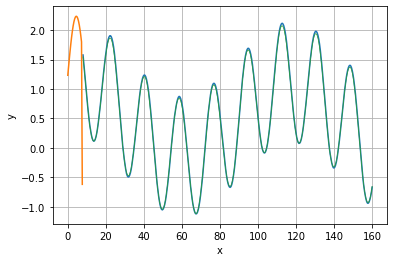

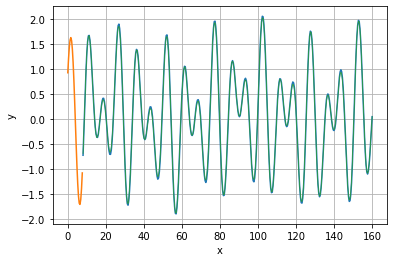

In [86]:
from sklearn.metrics import mean_absolute_error as mae
print(mae(y_out_val[pipe.num_samples:], y_out_pred[pipe.num_samples:]))
n_samp = int((pipe.xshape - pipe.n_steps))

plt.plot(t[pipe.n_steps:], y_out_pred[n_samp:], label="Prediction")
plt.plot(t[:pipe.n_steps], x_inp_val[n_samp, :-6], label="Input")
plt.plot(t[pipe.n_steps:], y_out_val[n_samp:], lw=0.7, label="Target")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.plot(t[pipe.n_steps:], y_out_pred[:n_samp], label="Prediction")
plt.plot(t[:pipe.n_steps], x_inp_val[0, :-6], label="Input")
plt.plot(t[pipe.n_steps:], y_out_val[:n_samp],  lw=0.7,label="Target")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
